In [1]:
########################################################################################################
#Tiago Tambonis - 2017 - 2018 - 2019 
#Observação: Cuidado com as definições de variáveis no arquivo Geração_imuno.sh e Geração_Non_imuno.sh.
#Na atual definição estou considerando somente 1 vizinho. Atenção ao scoring associado à GridSearch.
#Objetivo: avaliar os resultados preditivos sem uso do Suvrel.
#FEATURE SELECTION WITH MRMR.
########################################################################################################

In [3]:
#Imports 

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import pandas as pd
import numpy as np
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef, roc_auc_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pickle
from scipy.spatial.distance import squareform, pdist
from sklearn.model_selection import train_test_split
from scipy.stats import entropy

random_state=101

In [4]:
## Função Suvrel.

def suvrel(X, y, gamma=2.0, norm=None, distance=False):
    """
    Return: a metric tensor for the data
    X columns representing samples and lines dimentions
    y labels
    gamma is a float
    norm:{None,\"unity\",\"t-test\"}
    distance: {False, True} if True return a tuple (weights, D)
    where D is the distanca matrix of the data
    for the geometric approach method
    """

    classes = list(set(y))
    n_classes = len(classes)
    dim = X.shape[1]

    if norm is None or norm == "unity":
        mean_cl = np.zeros((n_classes, dim))
        for i, cl in enumerate(classes):
            mean_cl[i] = np.mean(X[y == cl], axis=0)

        smeans = np.zeros(dim)
        for i, j in combinations(range(n_classes), 2):
            smeans += (mean_cl[i] - mean_cl[j]) ** 2

        if gamma != 2:
            var_cl = np.zeros((n_classes, dim))
            for cl in classes:
                var_cl[cl] = np.var(X[y == cl], axis=0)
            svar = np.sum(var_cl, axis=0)
            weights = ((gamma - 2.) * svar 
                        +  gamma /( n_classes - 1) * smeans)
        else:
            weights = smeans

        weights[weights < 0] = 0

        if norm is "unity":
            weights = weights / np.var(X, axis=0)

        if distance:
            return (weights / np.sqrt(np.sum(weights ** 2)),
                    squareform(pdist(X * np.sqrt(weights))))
        else:
            return weights / np.sqrt(np.sum(weights ** 2))

    elif norm == "t-test":
        if n_classes == 2:
            mean_cl = np.zeros((n_classes, dim))
            var_cl = np.zeros((n_classes, dim))
            for i, cl in enumerate(classes):
                mean_cl[i] = np.mean(X[y == cl], axis=0)
                var_cl[i] = np.var(X[y == cl], axis=0)

            for i, j in combinations(range(n_classes), 2):
                smeans = (mean_cl[i] - mean_cl[j]) ** 2
                #tnorm = (var_cl[i] / np.sum([y == classes[i]])
                         #+ var_cl[j] / np.sum([y == classes[j]]))

                # case with equal variance. Edited by Marcelo 21/10/13
                n1 = np.sum([y == classes[i]])
                n2 = np.sum([y == classes[j]])
                tnorm = ((n1 - 1) * var_cl[i] + (n2 - 1) * var_cl[j]) \
                    / (n1 + n2 - 2)
            if gamma != 2:
                svar = np.sum(var_cl, axis=0)
                weights = ((gamma - 2.) * svar 
                            +  gamma /( n_classes - 1) * smeans)
            else:
                weights = smeans
            weights = weights / tnorm
            weights[weights < 0] = 0

            if distance:
                return (weights / np.sqrt(np.sum(weights ** 2)),
                        squareform(pdist(X * np.sqrt(weights))))
            else:
                return weights / np.sqrt(np.sum(weights ** 2))

        else:
            print ("error: for t-test normalization the number" +
                   " of classes must be equal 2")
            return None
    else:
        print "error: norm options are None, \"unity\" and  \"t-test\""
    return None

In [5]:
#Seed random

np.random.seed(seed=101)

In [6]:
#Carregar dados 

if False: 

    with open('../Sequencias/DadosTreinoFeaturizados', 'rb') as fp:
            DadosTreinoFeaturizados = pickle.load(fp)
    with open('../Sequencias/DadosTesteFeaturizados', 'rb') as fp:
            DadosTesteFeaturizados = pickle.load(fp)

if True: 

    with open('../Sequencias/DadosTreinoCru', 'rb') as fp:
            DadosTreinoFeaturizados = pickle.load(fp)
    with open('../Sequencias/DadosTesteCru', 'rb') as fp:
            DadosTesteFeaturizados = pickle.load(fp)

In [7]:
print(DadosTreinoFeaturizados.shape)
print(DadosTesteFeaturizados.shape)

(14103, 401)
(1568, 401)


In [8]:
DadosTreinoFeaturizados.head(n=3)

,GW,GV,GT,GS,GR,GQ,GP,GY,GG,GF,...,AQ,AP,AS,AR,AT,AW,AV,AY,VK,Classe
0,0.0,5.26,5.26,0.0,0.0,0.0,0.00,0.0,5.26,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,5.26,0.0,1.0
1,0.0,5.26,0.00,0.0,0.0,0.0,0.00,0.0,5.26,0.0,...,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0
2,0.0,0.00,0.00,0.0,0.0,0.0,5.26,0.0,0.00,0.0,...,0.0,5.26,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0


In [9]:
DadosTesteFeaturizados.head(n=3)

,GW,GV,GT,GS,GR,GQ,GP,GY,GG,GF,...,AQ,AP,AS,AR,AT,AW,AV,AY,VK,Classe
0,0.0,0.00,0.0,0.0,0.0,5.26,0.0,0.0,5.26,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,-1.0
1,0.0,5.26,0.0,0.0,0.0,0.00,0.0,0.0,5.26,0.0,...,0.0,0.0,0.0,5.26,0.0,0.0,0.0,0.0,0.0,-1.0
2,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,...,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,-1.0


# Run 

In [10]:
#se aumentar o krange os variâncias diminuem?

In [11]:
krange = 5
kfeature = DadosTreinoFeaturizados.shape[1]-1

ws = np.zeros((kfeature, krange))

for i in range(krange):
    
    y = np.array(DadosTreinoFeaturizados['Classe'])           

    X = np.array(DadosTreinoFeaturizados.drop(['Classe'], 1))

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2)
    X_treino_efetivo = np.copy(X_treino)

    #Normalização e featurização

    normalizar = True
    usarsuvrel = True

    if normalizar:

        scaler = StandardScaler()
        X_treino = scaler.fit(X_treino).transform(X_treino)
        #X_treino_efetivo = scaler.transform(X_treino_efetivo)

    if usarsuvrel: 

        w = suvrel(X=X_treino, y=y_treino)
        w = np.sqrt(w)

        X_treino_efetivo = w*X_treino_efetivo

    ws[:,i] = w

In [12]:
entropy(ws[:, 1], qk=ws[:, 0], base=None)

0.12717263116346755

In [13]:
wsliststd = ws.std(axis=1)

In [14]:
ws[:, 0].shape

(400,)

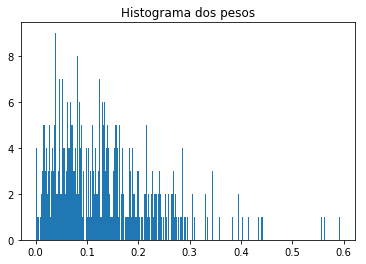

In [16]:
plt.hist(ws[:, 0], bins=300)  # arguments are passed to np.histogram
plt.title("Histograma dos pesos")
plt.show()

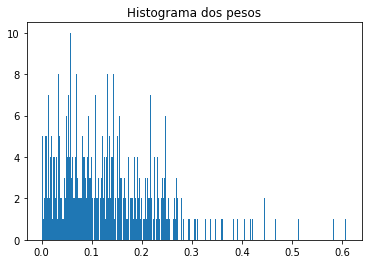

In [17]:
plt.hist(ws[:, 1], bins=300)  # arguments are passed to np.histogram
plt.title("Histograma dos pesos")
plt.show()

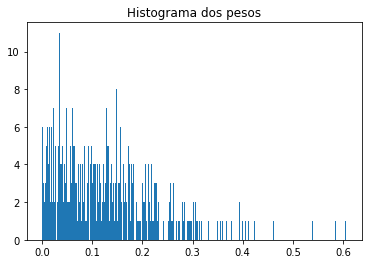

In [18]:
plt.hist(ws[:,2], bins=300)  # arguments are passed to np.histogram
plt.title("Histograma dos pesos")
plt.show()

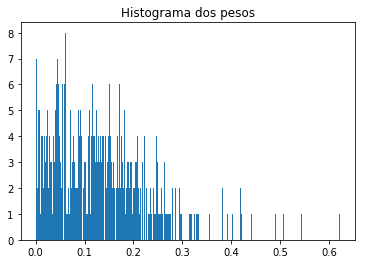

In [19]:
plt.hist(ws[:,3], bins=300)  # arguments are passed to np.histogram
plt.title("Histograma dos pesos")
plt.show()

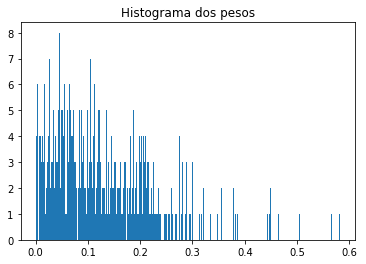

In [20]:
plt.hist(ws[:,4], bins=300)  # arguments are passed to np.histogram
plt.title("Histograma dos pesos")
plt.show()

In [21]:
np.sum(ws[:,4]**4)

1.0

In [22]:
ws.shape

(400, 5)

In [23]:
wsdf = pd.DataFrame(data=ws, index=(DadosTreinoFeaturizados.drop(['Classe'], 1)).columns, 
                   columns = ["s1", "s2", "s3", "s4", "s5"])

In [24]:
wsdf.head()

,s1,s2,s3,s4,s5
GW,0.039338,0.109821,0.014286,0.039092,0.176779
GV,0.230939,0.174309,0.221872,0.183414,0.210086
GT,0.017154,0.019296,0.033177,0.000774,0.023586
GS,0.052578,0.071274,0.022760,0.051230,0.008043
GR,0.015318,0.044871,0.035780,0.075125,0.036215


In [25]:
wsdf.iloc[np.where(wsdf['s1'] > 0.5)]

,s1,s2,s3,s4,s5
QQ,0.592985,0.583799,0.606721,0.622498,0.582474
QP,0.557212,0.609031,0.538799,0.541749,0.566781
PQ,0.562354,0.511759,0.585591,0.506896,0.504521


In [26]:
wsdf.iloc[np.where(wsdf['s2'] > 0.5)]

,s1,s2,s3,s4,s5
QQ,0.592985,0.583799,0.606721,0.622498,0.582474
QP,0.557212,0.609031,0.538799,0.541749,0.566781
PQ,0.562354,0.511759,0.585591,0.506896,0.504521


In [27]:
wsdf.iloc[np.where(wsdf['s3'] > 0.5)]

,s1,s2,s3,s4,s5
QQ,0.592985,0.583799,0.606721,0.622498,0.582474
QP,0.557212,0.609031,0.538799,0.541749,0.566781
PQ,0.562354,0.511759,0.585591,0.506896,0.504521


In [28]:
wsdf.iloc[np.where(wsdf['s4'] > 0.5)]

,s1,s2,s3,s4,s5
QQ,0.592985,0.583799,0.606721,0.622498,0.582474
QP,0.557212,0.609031,0.538799,0.541749,0.566781
PQ,0.562354,0.511759,0.585591,0.506896,0.504521


In [29]:
wsdf.iloc[np.where(wsdf['s5'] > 0.5)]

,s1,s2,s3,s4,s5
QQ,0.592985,0.583799,0.606721,0.622498,0.582474
QP,0.557212,0.609031,0.538799,0.541749,0.566781
PQ,0.562354,0.511759,0.585591,0.506896,0.504521


In [30]:
#x = DadosTreinoFeaturizados[['QQ', 'Classe']]

In [31]:
labels = np.array(DadosTreinoFeaturizados['Classe'])
kpositivos = np.sum(labels==1)
knegativos = np.sum(labels==-1)

In [32]:
kpositivos + knegativos

14103

In [33]:
DadosTreinoFeaturizados.shape

(14103, 401)

In [41]:
x = np.array(DadosTreinoFeaturizados['PQ'])

In [42]:
y = np.array(DadosTreinoFeaturizados['Classe'])

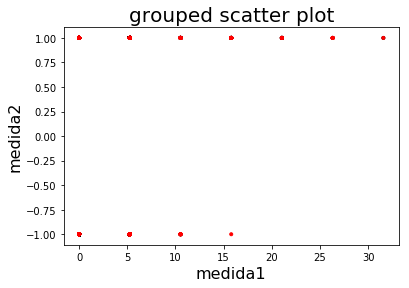

In [43]:
import matplotlib.pyplot as plt

color_array = ['black'] * kpositivos + ['r'] * knegativos
plt.scatter(x, y, marker='.', c=color_array)

plt.xlabel('medida1', fontsize=16)
plt.ylabel('medida2', fontsize=16)
plt.title('grouped scatter plot', fontsize=20)
#plt.xlim(5.2595+0.00045, 5.2605-0.0005)
#plt.savefig("test.eps", format="eps")
plt.show()

In [82]:
wsdf.to_csv("Pesos", sep=',')